#INCLUDES

In [ ]:
import re
import nltk
import spacy
import gensim
import operator
import matplotlib
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#DOWNLOADS

In [ ]:
!python -m spacy download en_core_web_md
import en_core_web_md

nlp = en_core_web_md.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train = pd.read_csv('train_split.csv')
validation = pd.read_csv('validation_split.csv')
test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/test.csv')

#DocPreprocess

In [ ]:
#Pasa a textos a minusculas, elimina stopwords, acentos, hashtags, menciones, caracteres especiales, urls,
#palabras de longitud 3 o menor y aplica lematizacion
class DocPreprocess:
  
  def __init__(self,nlp,stop_words,docs,allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM'],lem = True):
    
    self.nlp = nlp  # spacy nlp object
    self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
    self.docs = docs  # docs must be either list or numpy array or series of docs
    self.new_docs = [self.remove_URL(doc) for doc in self.docs]
    self.new_docs = [self.remove_mention(doc) for doc in self.new_docs]
    self.new_docs = [self.remove_hashtags(doc) for doc in self.new_docs]
    self.new_docs = [self.remove_special_characters(doc) for doc in self.new_docs]
    #Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long ( deacc: remove accent )
    self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc,min_len = 3 ,max_len = 15, deacc=True) for doc in self.new_docs]
    self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
    if (lem): self.new_docs = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]

  def make_simple_doc(self, simple_doc_tokens):
    simple_docs = []
    for doc_tokens in simple_doc_tokens:
      simple = " ".join(doc_tokens)  # concatenate back to a sentence
      simple_docs.append(simple)
    return simple_docs

  def remove_hashtags(self,doc):
    split_doc = doc.split(' ')
    for w in split_doc:
      if ('#' in w): split_doc.remove(w)
    return ' '.join(split_doc)
	
  def remove_special_characters(self,doc):
    return doc.replace('\n', ' ').replace('å', ' ').replace('ê', ' ').replace('û', ' ').replace('[^\w\s]',' ').replace('÷', ' ').replace('ª', ' ').replace('ì', ' ').replace('¢', ' ').replace('\x89', ' ').replace('\x9d', ' ').replace('ã', ' ').replace('ï', ' ').replace('©', ' ').replace('ó', ' ').replace('ò', ' ').replace('â', ' ').replace('\x9b', ' ').replace('\x8a', ' ').replace('\x93', ' ').replace('\x8f', ' ')\
             .replace('\x8c', ' ').replace('¼', ' ').replace('¥', ' ').replace('\x92', ' ').replace('·', ' ').replace('\x82', ' ').replace('Û', ' ').replace('Ó', ' ').replace('Ê', ' ').replace('Ï', ' ')

  def remove_URL(self,doc):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(doc))
	
  def remove_mention(self,doc):
    without_mention = []
    for w in doc.split(' '):
      if ('@' not in w):
        without_mention.append(w)
    return ' '.join(without_mention)

  def lemmatize(self, doc, allowed_postags):
    doc = self.nlp(str(doc))
    tokens = [token.lemma_ for token in doc if (
        token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
    return ' '.join(tokens)


In [ ]:
train_text_preprocess = DocPreprocess(nlp,stop_words,train.text, lem = True)
validation_text_preprocess = DocPreprocess(nlp,stop_words,validation.text, lem = True)
test_text_preprocess = DocPreprocess(nlp,stop_words,test.text, lem = True)

train['clean_text'] = train_text_preprocess.new_docs
validation['clean_text'] = validation_text_preprocess.new_docs
test['clean_text'] = test_text_preprocess.new_docs

#Word Frequency (Unigrams - Bigrams - Trigrams)

In [ ]:
docs_target1 = train[train['target'] == 1]['clean_text']
docs_target0 = train[train['target'] == 0]['clean_text']

#Concateno todos los mensajes y los tomo como un unico documento
lst_tokens_1 = nltk.tokenize.word_tokenize (docs_target1.str.cat(sep = ' '))
lst_tokens_0 = nltk.tokenize.word_tokenize (docs_target0.str.cat(sep = ' '))

In [ ]:
#Unigrams
dic_words_freq_target1 = nltk.FreqDist (lst_tokens_1)
dic_words_freq_target0 = nltk.FreqDist (lst_tokens_0)

dtf_uni_target1 = pd.DataFrame(dic_words_freq_target1.most_common (), columns = ['Word', 'Freq'])
dtf_uni_target0 = pd.DataFrame(dic_words_freq_target0.most_common (), columns = ['Word', 'Freq'])

#Bigrams

dic_words_freq_target1 = nltk.FreqDist (nltk.ngrams(lst_tokens_1, 2))
dic_words_freq_target0 = nltk.FreqDist (nltk.ngrams(lst_tokens_0, 2))

dtf_bi_target1 = pd.DataFrame (dic_words_freq_target1.most_common (),columns = ['Word', 'Freq']) 
dtf_bi_target1['Word'] = dtf_bi_target1['Word'].apply(lambda x: ' '.join (string for string in x))

dtf_bi_target0 = pd.DataFrame (dic_words_freq_target0.most_common (),columns = ['Word', 'Freq']) 
dtf_bi_target0['Word'] = dtf_bi_target0['Word'].apply(lambda x: ' '.join (string for string in x))

#Trigrams
dic_words_freq_target1 = nltk.FreqDist (nltk.ngrams(lst_tokens_1, 3))
dic_words_freq_target0 = nltk.FreqDist (nltk.ngrams(lst_tokens_0, 3))

dtf_tri_target1 = pd.DataFrame (dic_words_freq_target1.most_common (),columns = ['Word', 'Freq']) 
dtf_tri_target1['Word'] = dtf_tri_target1['Word'].apply(lambda x: ' '.join (string for string in x))

dtf_tri_target0 = pd.DataFrame (dic_words_freq_target0.most_common (),columns = ['Word', 'Freq']) 
dtf_tri_target0['Word'] = dtf_tri_target0['Word'].apply(lambda x: ' '.join (string for string in x))

In [ ]:
unigrams_target1 = set(dtf_uni_target1.Word)
unigrams_target0 = set(dtf_uni_target0.Word)

bigrams_target1 = set(dtf_bi_target1.Word)
bigrams_target0 = set(dtf_bi_target0.Word)

trigrams_target1 = set(dtf_tri_target1.Word)
trigrams_target0 = set(dtf_tri_target0.Word)

In [ ]:
# unique unigram

aux = unigrams_target1
unigrams_target1 = unigrams_target1 - unigrams_target0
unigrams_target0 = unigrams_target0 - aux

In [ ]:
# unique bigram

aux = bigrams_target1
bigrams_target1 = bigrams_target1 - bigrams_target0
bigrams_target0 = bigrams_target0 - aux

In [ ]:
# unique trigram

aux = trigrams_target1
trigrams_target1 = trigrams_target1 - trigrams_target0
trigrams_target0 = trigrams_target0 - aux

In [ ]:
dtf_uni_target1 = dtf_uni_target1[dtf_uni_target1.Word.isin(unigrams_target1)]
dtf_uni_target0 = dtf_uni_target0[dtf_uni_target0.Word.isin(unigrams_target0)]

In [ ]:
dtf_bi_target1 = dtf_bi_target1[dtf_bi_target1.Word.isin(bigrams_target1)]
dtf_bi_target0 = dtf_bi_target0[dtf_bi_target0.Word.isin(bigrams_target0)]

In [ ]:
dtf_tri_target1 = dtf_tri_target1[dtf_tri_target1.Word.isin(trigrams_target1)]
dtf_tri_target0 = dtf_tri_target0[dtf_tri_target0.Word.isin(trigrams_target0)]

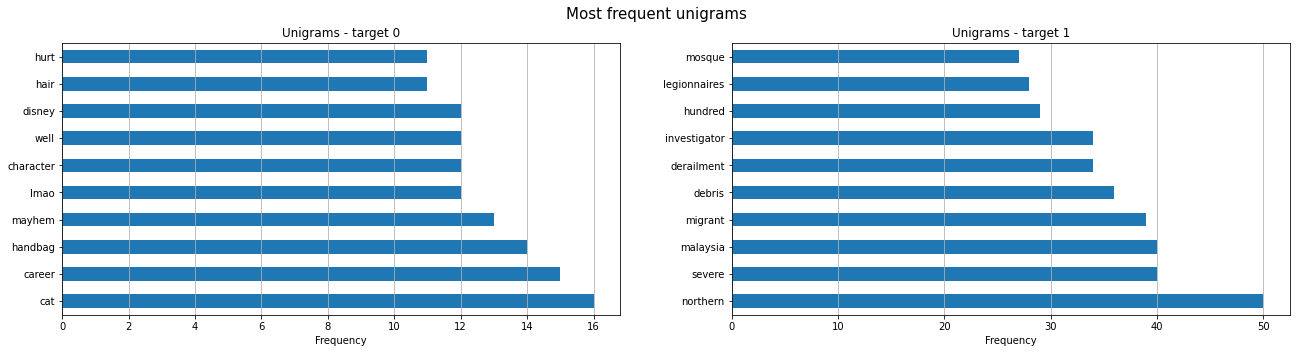

In [ ]:
#Unigrams

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (22,5))
fig.suptitle('Most frequent unigrams', fontsize = 15)

dtf_uni_target1.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Unigrams - target 1', ax = ax[1], legend = False)
dtf_uni_target0.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Unigrams - target 0', ax = ax[0], legend = False)

ax[0].grid (axis = 'x')
ax[1].grid (axis = 'x') 

ax[0].set(ylabel = None, xlabel = 'Frequency')
ax[1].set(ylabel = None, xlabel = 'Frequency')
 

plt.show()

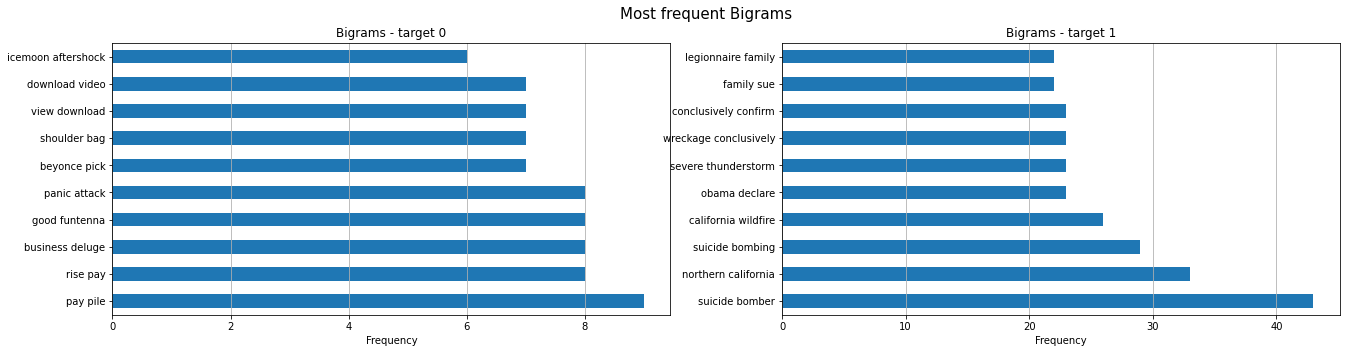

In [ ]:
#Bigrams

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (22,5))
fig.suptitle('Most frequent Bigrams', fontsize = 15)

dtf_bi_target1.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Bigrams - target 1', ax = ax[1], legend = False)
dtf_bi_target0.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Bigrams - target 0', ax = ax[0], legend = False)

ax[0].grid (axis = 'x')
ax[1].grid (axis = 'x') 

ax[0].set(ylabel = None,xlabel = 'Frequency')
ax[1].set(ylabel = None,xlabel = 'Frequency')
 

plt.show()

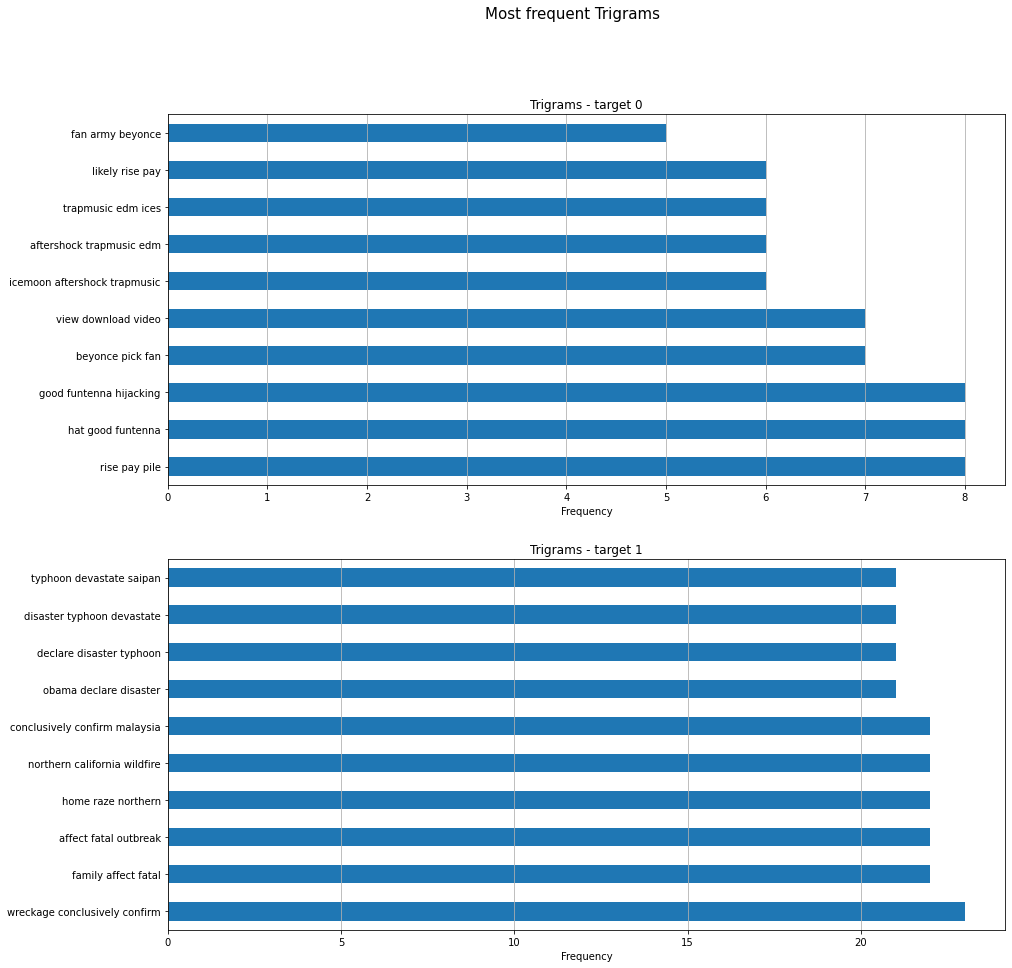

In [ ]:
#Trigrams

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize = (15,15))
fig.suptitle('Most frequent Trigrams', fontsize = 15)

dtf_tri_target1.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Trigrams - target 1', ax = ax[1], legend = False)
dtf_tri_target0.set_index('Word').iloc [:10 ,: ].plot(kind = 'barh', title = 'Trigrams - target 0', ax = ax[0], legend = False)

ax[0].grid (axis = 'x')
ax[1].grid (axis = 'x') 

ax[0].set(ylabel = None,xlabel = 'Frequency')
ax[1].set(ylabel = None,xlabel = 'Frequency')
 

plt.show()

In [ ]:
def contain_n_gram(doc,n_gram, n = 1):
  words = nltk.tokenize.word_tokenize(doc)
  n_grams_doc = nltk.ngrams(words, n)
  for x in n_grams_doc:
    if (n_gram in ' '.join(x)): return True
  return False

In [ ]:
top = 300

top_unigram_target1 = list(dtf_uni_target1.Word.iloc[:top])
top_unigram_target0 = list(dtf_uni_target0.Word.iloc[:top])

top_bigram_target1 = list(dtf_bi_target1.Word.iloc[:top])
top_bigram_target0 = list(dtf_bi_target0.Word.iloc[:top])

top_trigram_target1 = list(dtf_tri_target1.Word.iloc[:top])
top_trigram_target0 = list(dtf_tri_target0.Word.iloc[:top])

In [ ]:
unigrams = (top_unigram_target1) + (top_unigram_target0)
bigrams = (top_bigram_target1) + (top_bigram_target0)
trigrams = (top_trigram_target1) + (top_trigram_target0)

In [ ]:
bag_of_unigrams_train = pd.DataFrame({'id':list(train.id)})
bag_of_bigrams_train = pd.DataFrame({'id':list(train.id)})
bag_of_trigrams_train = pd.DataFrame({'id':list(train.id)})

bag_of_unigrams_validation = pd.DataFrame({'id':list(validation.id)})
bag_of_bigrams_validation = pd.DataFrame({'id':list(validation.id)})
bag_of_trigrams_validation = pd.DataFrame({'id':list(validation.id)})

bag_of_unigrams_test = pd.DataFrame({'id':list(test.id)})
bag_of_bigrams_test = pd.DataFrame({'id':list(test.id)})
bag_of_trigrams_test = pd.DataFrame({'id':list(test.id)})

In [ ]:
for unigram in unigrams:
  bag_of_unigrams_train[unigram] = train.clean_text.apply(lambda x: 1 if (contain_n_gram(x,unigram)) else 0 )
  bag_of_unigrams_validation[unigram] = validation.clean_text.apply(lambda x: 1 if (contain_n_gram(x,unigram)) else 0)
  bag_of_unigrams_test[unigram] = test.clean_text.apply(lambda x: 1 if (contain_n_gram(x,unigram)) else 0)

In [ ]:
for bigram in bigrams:
  bag_of_bigrams_train[bigram] = train.clean_text.apply(lambda x: 1 if (contain_n_gram(x,bigram,n = 2)) else 0 )
  bag_of_bigrams_validation[bigram] = validation.clean_text.apply(lambda x: 1 if (contain_n_gram(x,bigram,n = 2)) else 0 )
  bag_of_bigrams_test[bigram] = test.clean_text.apply(lambda x: 1 if (contain_n_gram(x,bigram,n = 2)) else 0 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


In [ ]:
for trigram in trigrams:
  bag_of_trigrams_train[trigram] = train.clean_text.apply(lambda x: 1 if (contain_n_gram(x,trigram,n = 3)) else 0 )
  bag_of_trigrams_validation[trigram] = validation.clean_text.apply(lambda x: 1 if (contain_n_gram(x,trigram,n = 3)) else 0 )
  bag_of_trigrams_test[trigram] = test.clean_text.apply(lambda x: 1 if (contain_n_gram(x,trigram,n = 3)) else 0 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


#EXPORTO

In [ ]:
bag_of_unigrams_train['target'] = list(train.target)
bag_of_unigrams_validation['target'] = list(validation.target)

bag_of_bigrams_train['target'] = list(train.target)
bag_of_bigrams_validation['target'] = list(validation.target)

bag_of_trigrams_train['target'] = list(train.target)
bag_of_trigrams_validation['target'] = list(validation.target)

In [ ]:
print(bag_of_unigrams_train.shape)
print(bag_of_bigrams_train.shape)
print(bag_of_trigrams_train.shape)

(6090, 602)
(6090, 602)
(6090, 602)


In [ ]:
bag_of_unigrams_train.to_csv('bag_of_unigrams_train.csv',header = True, index = False)
bag_of_unigrams_validation.to_csv('bag_of_unigrams_validation.csv',header = True, index = False)
bag_of_unigrams_test.to_csv('bag_of_unigrams_test.csv',header = True, index = False)

In [ ]:
bag_of_bigrams_train.to_csv('bag_of_bigrams_train.csv',header = True, index = False)
bag_of_bigrams_validation.to_csv('bag_of_bigrams_validation.csv',header = True, index = False)
bag_of_bigrams_test.to_csv('bag_of_bigrams_test.csv',header = True, index = False)

In [ ]:
bag_of_trigrams_train.to_csv('bag_of_trigrams_train.csv',header = True, index = False)
bag_of_trigrams_validation.to_csv('bag_of_trigrams_validation.csv',header = True, index = False)
bag_of_trigrams_test.to_csv('bag_of_trigrams_test.csv',header = True, index = False)